<a href="https://colab.research.google.com/github/venkatesh1226/CMPE255-DataMining/blob/main/Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle: https://www.kaggle.com/datasets/brsdincer/climate-change-video-set-nasa/data


In [1]:
import zipfile
import os

# Unzipping the provided dataset
zip_path = "/content/drive/MyDrive/DM_Assignment_05/video/climatechange-video-dataset.zip"
unzip_dir = "/content/drive/MyDrive/DM_Assignment_05/video/climatechange-video-dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Checking the contents of the extracted folder
extracted_files = os.listdir(unzip_dir)
extracted_files


['climate', 'frames']

In [2]:
# Checking the contents of the 'climate' folder
climate_folder_contents = os.listdir(os.path.join(unzip_dir, 'climate'))
climate_folder_contents


['0the5j_1.mp4', 'nsceeu_1.mp4']

Typically, for video datasets, features might include:

Metadata Features: Duration, resolution, frame rate, etc.

Visual Features: Histograms, color distribution, object detection counts, etc.

Audio Features (if the video has audio): Frequency distribution, volume levels, etc.

Textual Features: If there are any subtitles or recognizable texts, we can extract keywords, sentiment, etc.

### EDA

In [7]:
import cv2

def video_metadata(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    duration = float(total_frames) / fps
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    return {
        "total_frames": total_frames,
        "fps": fps,
        "duration(s)": duration,
        "resolution": f"{width}x{height}"
    }

video_path = '/content/drive/MyDrive/DM_Assignment_05/video/climatechange-video-dataset/climate/nsceeu_1.mp4'  # Update this path
metadata = video_metadata(video_path)
print(metadata)


{'total_frames': 380, 'fps': 30, 'duration(s)': 12.666666666666666, 'resolution': '1280x576'}


### 2. Check for Missing Values:

We'll check if there are any unreadable or corrupted frames.

In [8]:
def check_corrupted_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    unreadable_frames = []

    for i in range(total_frames):
        ret, _ = cap.read()
        if not ret:
            unreadable_frames.append(i)

    cap.release()
    return unreadable_frames

corrupted = check_corrupted_frames(video_path)
print(f"Number of corrupted frames: {len(corrupted)}")


Number of corrupted frames: 0


###3. Visualize Relationships Between Features:

For videos, one way to visualize relationships is to examine pixel value distributions or color histograms. Here's a basic way to visualize the color distribution for a sample frame:

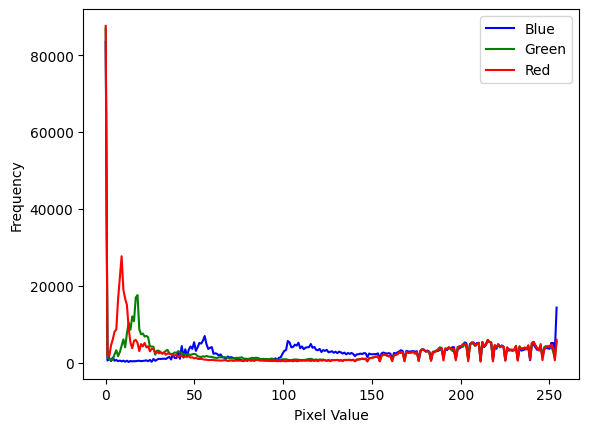

In [9]:
import matplotlib.pyplot as plt
import numpy as np
def plot_color_histogram(frame):
    for i, color in enumerate(['b', 'g', 'r']):
        histogram, bin_edges = np.histogram(
            frame[:, :, i], bins=256, range=(0, 255)
        )
        plt.plot(bin_edges[0:-1], histogram, color=color)

    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend(['Blue', 'Green', 'Red'])
    plt.show()

# Extract a sample frame for visualization
cap = cv2.VideoCapture(video_path)
_, sample_frame = cap.read()
cap.release()

plot_color_histogram(sample_frame)


### Data Preprocessing

1. Handle Missing Values:
If a frame is unreadable or corrupt, one approach is to interpolate between the previous and next frames. Given that our earlier function identified unreadable frames, we can interpolate as follows:

In [10]:
def interpolate_missing_frames(video_path, unreadable_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(total_frames):
        ret, frame = cap.read()
        if i in unreadable_frames:
            prev_frame = frames[-1]
            ret_next, next_frame = cap.read()
            if ret_next:
                interpolated_frame = cv2.addWeighted(prev_frame, 0.5, next_frame, 0.5, 0)
                frames.append(interpolated_frame)
                cap.set(cv2.CAP_PROP_POS_FRAMES, i+1)  # Resetting the frame position
            else:
                frames.append(prev_frame)  # If next frame is also not readable, use the previous frame
        elif ret:
            frames.append(frame)

    cap.release()
    return frames

frames = interpolate_missing_frames(video_path, corrupted)


2. Remove Outliers or Anomalies:
Detecting outliers in video data can be complex. One simple approach is to detect frames that have a sudden change in brightness or color distribution, which might indicate anomalies:

In [11]:
def detect_anomalous_frames(frames):
    avg_brightness = [np.mean(frame) for frame in frames]
    brightness_diff = np.diff(avg_brightness)
    threshold = np.mean(brightness_diff) + 2*np.std(brightness_diff)
    anomalies = np.where(np.abs(brightness_diff) > threshold)[0]
    return anomalies

anomalous_frames = detect_anomalous_frames(frames)
print(f"Anomalous frames detected at indices: {anomalous_frames}")


Anomalous frames detected at indices: [  0  23  26  36  40  63  66  76  80 103 106 116 120 143 147 156 160 183
 187 196 200 223 227 236 240 263 266 276 280 303 307 343 347 356 363]


3. Normalize/Standardize Data:
Normalize pixel values to be between 0 and 1:

In [12]:


normalized_frames = [(frame/255.0).astype(np.float32) for frame in frames]



### 1. Feature Engineering:
a. Motion Vectors:
One useful feature for videos is the motion between consecutive frames. This can be calculated using optical flow, which captures the apparent motion of objects between two consecutive frames:

In [13]:
def calculate_optical_flow(prev_frame, curr_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

optical_flows = [calculate_optical_flow(normalized_frames[i], normalized_frames[i+1]) for i in range(len(normalized_frames)-1)]

b. Color Histograms:

We can represent the color distribution of frames using histograms:

In [10]:
def calculate_color_histogram(frame):
    histogram = [cv2.calcHist([frame], [i], None, [256], [0, 256]) for i in range(3)]
    return np.concatenate(histogram)

color_histograms = [calculate_color_histogram(frame) for frame in normalized_frames]


2. Feature Selection:

For video data, feature selection is often task-specific. For example, if you're classifying scenes, color histograms might be more relevant. If you're tracking objects, motion vectors might be crucial. Here, we'll assume both sets of features are relevant, but in practice, you'd use techniques like Principal Component Analysis (PCA) or feature importance from tree-based models to reduce dimensionality or select the most relevant features.

### 3. Clustering:

a. Identify Clusters:
We can use clustering to group similar frames or segments. One common method is KMeans. Here, we'll cluster based on color histograms:

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

color_histograms_2d = np.array(color_histograms).reshape(len(color_histograms), -1)

n_clusters = 2  # Adjust based on your needs
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(color_histograms_2d)

print(clusters)






/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]


b. Label Data:

The clusters array now contains labels for each frame, indicating which cluster it belongs to. These clusters could potentially represent different scenes or segments in the video.

###4. Anomaly Detection:

To detect anomalies, we can use models like Isolation Forest or One-Class SVM. For simplicity, we'll use Isolation Forest on the color histograms:

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination parameter based on your needs
outliers = iso_forest.fit_predict(color_histograms_2d)

anomalies = np.where(outliers == -1)[0]
print(f"Anomalous frames detected at indices: {anomalies}")


### Model Building using LSTM:

Prepare Sequential Data:
For training LSTMs, we need to structure our data into sequences. If we're using optical flows (motion vectors) as features:

In [ ]:
SEQUENCE_LENGTH = 5

def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length])
    return np.array(sequences), np.array(target)

X, Y = create_sequences(optical_flows, SEQUENCE_LENGTH)


Define LSTM Model:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(30, activation='relu', return_sequences=False),
        Dense(input_shape[1]*input_shape[2], activation='linear')  # Regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_model(X.shape[1:])

\

### 1. Extract Frames from Videos:
To extract frames from videos, you can use the OpenCV library.

In [7]:
import cv2
import os

def extract_frames(video_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite(os.path.join(save_folder, "frame{:d}.jpg".format(count)), image)
        success, image = vidcap.read()
        count += 1


# Example usage:
video_path = '/content/drive/MyDrive/DM_Assignment_05/video/climatechange-video-dataset/climate/nsceeu_1.mp4'
save_folder = '/content/drive/MyDrive/DM_Assignment_05/video/climatechange-video-dataset/frames/nsceeu_1'
extract_frames(video_path, save_folder)


### 2. Preprocess Frames:

Resize and normalize the frames.

In [8]:
from PIL import Image
import numpy as np

def preprocess_frames(folder_path, size=(128, 128)):
    frames = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(size, Image.ANTIALIAS)
            frames.append(np.array(img) / 255.0)
    return np.array(frames)

frames = preprocess_frames(save_folder)


<ipython-input-8-88ee7d0df6ad>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


### 3. ConvLSTM Model for Frame Prediction:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization

def build_model(input_shape):
    model = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=True, input_shape=input_shape, padding='same'),
        BatchNormalization(),

        ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=True, padding='same'),
        BatchNormalization(),

        ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, padding='same'),
        BatchNormalization(),

        tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Assuming you want to use 10 frames to predict the 11th frame
SEQUENCE_LENGTH = 10

X = [frames[i:i+SEQUENCE_LENGTH] for i in range(len(frames) - SEQUENCE_LENGTH - 1)]
Y = [frames[i+SEQUENCE_LENGTH] for i in range(len(frames) - SEQUENCE_LENGTH - 1)]

X = np.array(X)
Y = np.array(Y)

model = build_model((SEQUENCE_LENGTH, *frames.shape[1:]))
model.fit(X, Y, epochs=50, batch_size=2)  # Training settings can be adjusted based on your needs


### 4. Predicting Future Frames:

After training, you can use the model to predict future frames.

In [ ]:
def predict_next_frame(model, input_sequence):
    predicted_frame = model.predict(np.expand_dims(input_sequence, axis=0))[0]
    return predicted_frame

# Using the last 10 frames to predict the next frame
input_sequence = frames[-SEQUENCE_LENGTH:]
predicted_frame = predict_next_frame(model, input_sequence)

# To visualize the predicted frame
import matplotlib.pyplot as plt

plt.imshow(predicted_frame)
plt.show()
